# Author: Стурейко Игорь
## Project: Geekbrains.Algorithms
## Курсовой проект - бинарная классификация
## Date: 2020-09-13

## Description:
Предсказать вероятность того, подойдет ли репетитор для подготовки к экзамену по математике

Link: https://www.kaggle.com/c/choose-tutors/overview

Data: https://www.kaggle.com/c/choose-tutors/data

### Импорт библиотек

In [1]:
# Вырубить предупреждения
import warnings
warnings.filterwarnings('ignore')

# Стандартные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from sklearn.model_selection import train_test_split

%matplotlib inline

# импортировать алгоритмы
from DesisionTree import DesisionTree, accuracy_metric
from RandomForestDesign import RandomForestDesign
from sklearn.tree import DecisionTreeClassifier
from Boosting import Boosting

In [2]:
# Прочитать данные
df = pd.read_csv('./train.csv')

In [3]:
df.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
# Обрезаем ненужные типы данных - облегчаем датафрейм в памяти
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.99 MB
Memory usage after optimization is: 0.45 MB
Decreased by 54.8%


In [6]:
# Готовим финальную выборку
X = df.drop('choose', axis=1)
y = df[['choose']]

X_final = pd.read_csv('./test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 10000
Строк в тесте 10000


## Предобработка данных

### Проверка на выбросы и пропуски данных

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  float32
 1   years_of_experience  10000 non-null  float32
 2   lesson_price         10000 non-null  float32
 3   qualification        10000 non-null  float32
 4   physics              10000 non-null  float32
 5   chemistry            10000 non-null  float32
 6   biology              10000 non-null  float32
 7   english              10000 non-null  float32
 8   geography            10000 non-null  float32
 9   history              10000 non-null  float32
 10  mean_exam_points     10000 non-null  float32
dtypes: float32(11)
memory usage: 507.8 KB


In [8]:
X.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000
mean,45.800900,1.974800,1702.439941,1.72430,0.370600,0.121500,0.117200,0.05910,0.027700,0.01800,64.435204
std,8.030277,1.766907,523.784851,0.79884,0.482989,0.326733,0.321674,0.23581,0.164115,0.13295,13.594976
min,23.000000,0.000000,200.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,33.000000
25%,40.000000,0.000000,1300.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,55.000000
50%,46.000000,2.000000,1550.000000,2.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,63.000000
75%,51.000000,3.000000,2150.000000,2.00000,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000,74.000000
max,68.000000,9.000000,3950.000000,4.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,100.000000


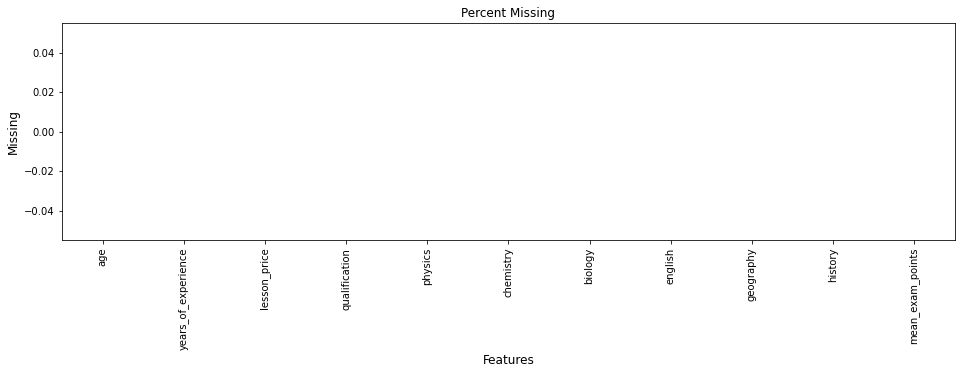

In [9]:
# Посмотрим на пропуски
nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Пропусков в данных нет - уже хорошо

### Мартица корреляций

In [10]:
df_num_features = X.select_dtypes(include='float32')
df_num_features.columns

Index(['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
       'mean_exam_points'],
      dtype='object')

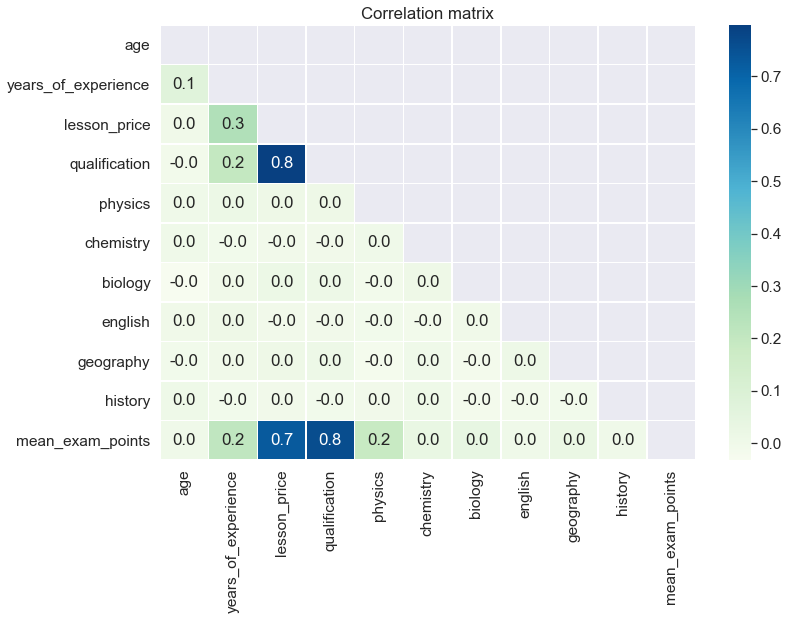

In [11]:
num_features = pd.DataFrame(df_num_features)
corr = num_features.corr()
plt.figure(figsize = (12, 8))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

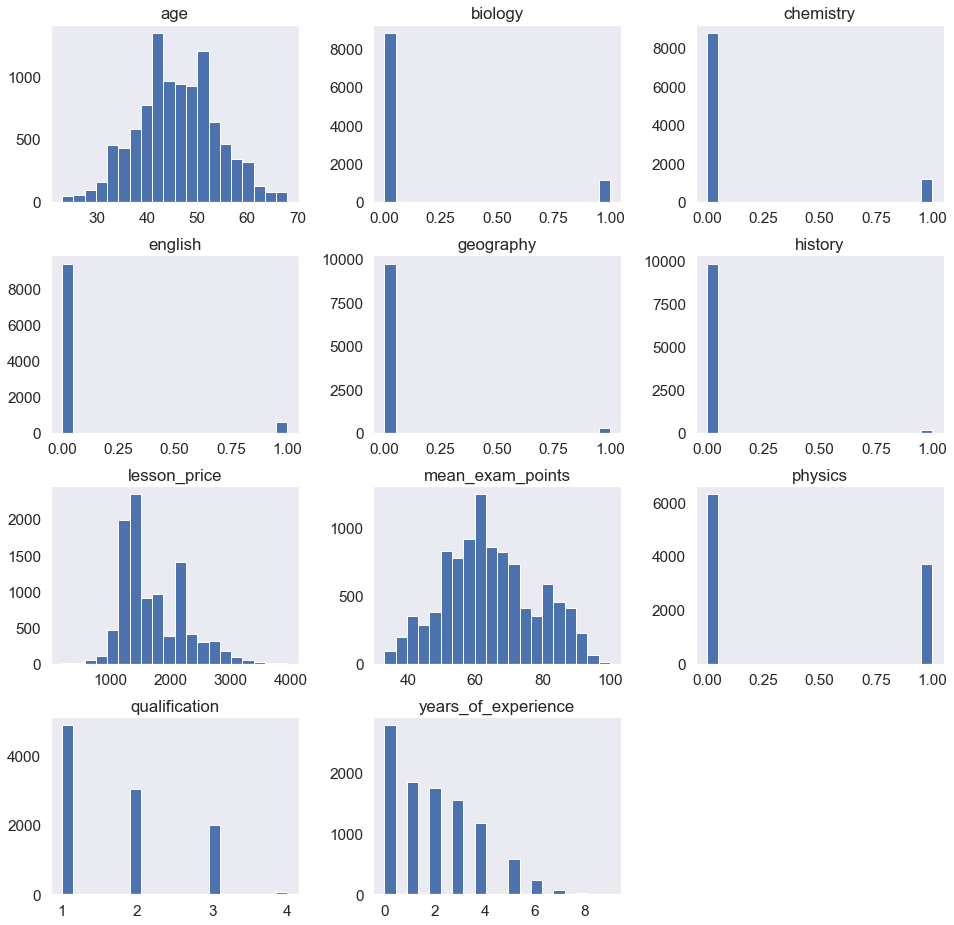

In [12]:
X.hist(figsize=(16,16), bins=20, grid=False);

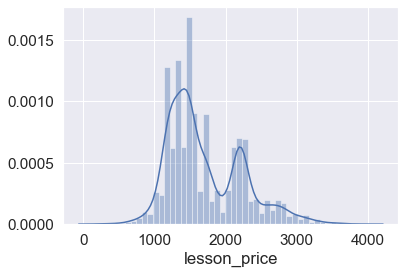

In [13]:
# Обратить внимание - есть выбросы - возможно сгладить данные
sns.distplot(X['lesson_price'])
plt.show()

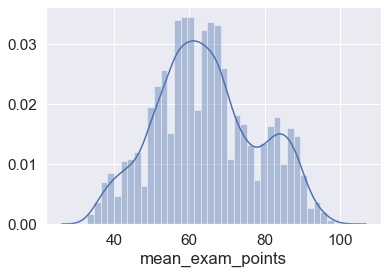

In [14]:
sns.distplot(X['mean_exam_points'])
plt.show()

In [15]:
X_lg = np.array(df.drop('choose', axis=1))
y_lg = np.array(df[['choose']]).T[0]

In [16]:
# разобъем на тест и трейн для опробывания модели
X_train, X_test, y_train, y_test = train_test_split(X_lg, y_lg, 
                                                    shuffle=True,
                                                    stratify = y,
                                                    test_size=0.3, random_state=42)

## Гипотезы

### Решающий лес

In [17]:
X_train.shape

(7000, 12)

In [18]:
# y_train = np.array(y_train[['choose']]).T[0]
y_train.shape

(7000,)

In [19]:
X_test.shape

(3000, 12)

In [20]:
# y_test = np.array(y_test[['choose']]).T[0]
y_test.shape

(3000,)

In [21]:
def print_score(method, n_trees, max_depth, num_leaves, min_samples_leaf, criteria, train_answers, test_answers):
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(y_train, train_answers)
    print(f'\n\n{method}\n')
    print(f'n_trees={n_trees},\
max_depth={max_depth},\
num_leaves={num_leaves},\
min_samples_leaf={min_samples_leaf}, \
criteria={criteria}')
    print(f' Точность на обучающей выборке: {train_accuracy:.3f}')

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(y_test, test_answers)
    print(f' Точность на тестовой выборке: {test_accuracy:.3f}')

In [22]:
n_trees = 10
max_depth=60
num_leaves=5
min_samples_leaf=5
criteria='gini'

my_forest_1 = RandomForestDesign(n_trees=n_trees,
                                 max_depth=max_depth,
                                 num_leaves=num_leaves,
                                 min_samples_leaf=min_samples_leaf,
                                 criteria=criteria)
my_forest_1.fit(X_train, y_train)
train_answers = my_forest_1.tree_vote(X_train)
test_answers = my_forest_1.tree_vote(X_test)

print_score('Random forest', n_trees, max_depth, num_leaves, min_samples_leaf, criteria, train_answers, test_answers)

# # Точность на обучающей выборке
# train_accuracy = accuracy_metric(y_train, train_answers)
# print('\n\nRandom forest\n')
# print(f' Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# # Точность на тестовой выборке
# test_accuracy = accuracy_metric(y_test, test_answers)
# print(f' Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')




Random forest

n_trees=10,max_depth=60,num_leaves=5,min_samples_leaf=5, criteria=gini
 Точность на обучающей выборке: 88.914
 Точность на тестовой выборке: 88.900


In [ ]:
n_trees = 10
max_depth=60
num_leaves=5
min_samples_leaf=5

num_leaves_f=0
min_samples_leaf_f=0
train_accuracy_f = 0
test_accuracy_f = 0

for n_trees in [5, 7, 10, 12, 15, 17, 20]:
    for max_depth in [30, 40, 50, 60, 70, 80, 90, 100]:
        for num_leaves in [3, 5, 8, 10]:
            for min_samples_leaf in [3, 5, 8, 10]:
                my_forest_1 = RandomForestDesign(n_trees=n_trees,
                                 max_depth=max_depth,
                                 num_leaves=num_leaves,
                                 min_samples_leaf=min_samples_leaf,
                                 criteria=criteria)
                my_forest_1.fit(X_train, y_train)
                train_answers = my_forest_1.tree_vote(X_train)
                test_answers = my_forest_1.tree_vote(X_test)
                train_accuracy = accuracy_metric(y_train, train_answers)
                test_accuracy = accuracy_metric(y_test, test_answers)
                if test_accuracy > test_accuracy_f:
                    test_accuracy_f = test_accuracy
                    train_accuracy_f = train_accuracy
                    n_trees_f = n_trees
                    max_depth_f = max_depth
                    num_leaves_f=num_leaves
                    min_samples_leaf_f=min_samples_leaf

print(f'Наилучшие параметры:\nn_trees_f = {n_trees}, max_depth_f = {max_depth}, \
num_leaves_f={num_leaves}, min_samples_leaf_f={min_samples_leaf},\n\
Точность на обучающей выборке:{train_accuracy_f:.4f}\n\
Точность на тестовой выборке;{test_accuracy_b:.4f}')

In [23]:
#  Точность случайного леса из 10 деревьев на обучающей выборке: 95.529
# Точность случайного леса из 10 деревьев на тестовой выборке: 88.933

In [24]:
# X_final = pd.read_csv('./test.csv')
# X_final_np = np.array(X_final)

In [25]:
# Получим ответы для тестовой выборки 
# test_answers = my_forest_1.tree_vote(X_final_np)

In [26]:
# preds_final['choose'] = test_answers

In [27]:
# preds_final.to_csv('predictions_base_1.csv', index=False)

## Boosting

In [34]:
# n_trees = 100
# max_depth=5
# num_leaves=5
# min_samples_leaf=5

# model_b = Boosting(n_trees=n_trees,
#                    max_depth=max_depth,
#                    num_leaves=num_leaves,
#                    min_samples_leaf=min_samples_leaf)
# model_b.fit(X_train, y_train)
# train_answers_b = model_b.predict(X_train)
# test_answers_b = model_b.predict(X_test)

# print_score('Gradient boosting', n_trees, max_depth, num_leaves, min_samples_leaf, criteria, train_answers_b, test_answers_b)

In [35]:
num_leaves_f=0
min_samples_leaf_f=0
train_accuracy_f = 0
test_accuracy_f = 0

for n_trees in [50, 100, 150, 200]:
    for max_depth in [5, 7, 10, 13]:
        for num_leaves in [3, 5, 8, 10]:
            for min_samples_leaf in [3, 5, 8, 10]:
                model_b = Boosting(n_trees=n_trees,
                           max_depth=max_depth,
                           num_leaves=num_leaves,
                           min_samples_leaf=min_samples_leaf)
                model_b.fit(X_train, y_train)
                train_answers_b = model_b.predict(X_train)
                test_answers_b = model_b.predict(X_test)
                train_accuracy_b = accuracy_metric(y_train, train_answers_b)
                test_accuracy_b = accuracy_metric(y_test, test_answers_b)
                if test_accuracy_b > test_accuracy_f:
                    test_accuracy_f = test_accuracy_b
                    train_accuracy_f = train_accuracy_b
                    n_trees_f = n_trees
                    max_depth_f = max_depth
                    num_leaves_f=num_leaves
                    min_samples_leaf_f=min_samples_leaf

print(f'Наилучшие параметры:\nn_trees_f = {n_trees}, max_depth_f = {max_depth}, \
num_leaves_f={num_leaves}, min_samples_leaf_f={min_samples_leaf},\n\
Точность на обучающей выборке:{train_accuracy_f:.4f}\n\
Точность на тестовой выборке;{test_accuracy_b:.4f}')

Наилучшие параметры:
n_trees_f = 200, max_depth_f = 13, num_leaves_f=10, min_samples_leaf_f=10,
Точность на обучающей выборке:90.0000
Точность на тестовой выборке;89.0667
